# Demonstration of HAVOK Method

In [1]:
import os
from functools import partial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import odeint
from plot_utils import scatter_plot_3d

#rcParams.update({'font.size': 14})
#plt.rcParams['figure.figsize'] = [12, 12]

In [2]:
# Directory for plot outputs
plot_dir = '../../plots'

## Simulate the Lorenz System

In [3]:
dt = 0.01
T = 50
t = np.arange(0,T+dt,dt)
beta = 8/3
sigma = 10
rho = 28

def lorenz_odes(t, y, sigma, beta, rho):
    """The Lorenz system of ordinary differential equations.
    
    Returns:
        dydt (tuple): Derivative w.r.t. time
    """
    y1, y2, y3 = y
    return (sigma * (y2 - y1), y1 * (rho - y3) - y2, y1 * y2 - beta * y3)

# Test calculation
assert lorenz_odes(0, (-8, 8, 27), sigma, beta, rho) == (160, -16, -136.0)

In [4]:
# Simulate using scipy.integrate.odeint method
# Produces same results as Matlab

# Initial condition
x0 = (-8, 8, 27)
fun = partial(lorenz_odes, sigma=sigma, beta=beta, rho=rho)
rtol = 10e-12
atol = 10e-12
x = odeint(fun, x0, t, tfirst=True, rtol=rtol, atol=atol)
assert x.shape == (5001, 3)

x[:5, :].round(3)

array([[-8.   ,  8.   , 27.   ],
       [-6.486,  7.803, 25.726],
       [-5.138,  7.563, 24.609],
       [-3.942,  7.313, 23.629],
       [-2.882,  7.078, 22.766]])

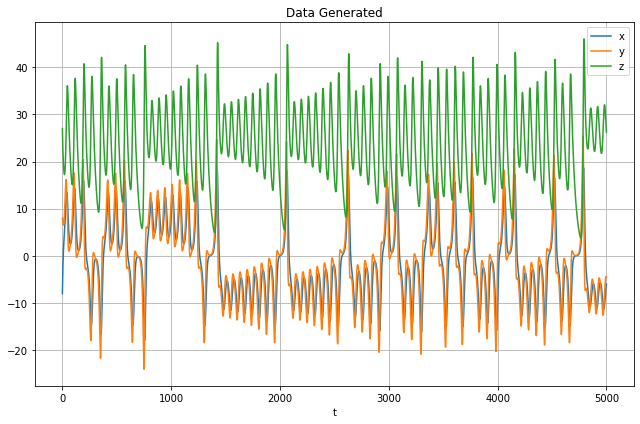

In [5]:
plt.figure(figsize=(9, 6))
plt.plot(x)
plt.title('Data Generated')
plt.xlabel('t')
plt.legend(labels=['x', 'y', 'z'])
plt.grid()
plt.tight_layout()
filepath = os.path.join(plot_dir, 'lorenz_data.png')
plt.savefig(filepath)
plt.show()

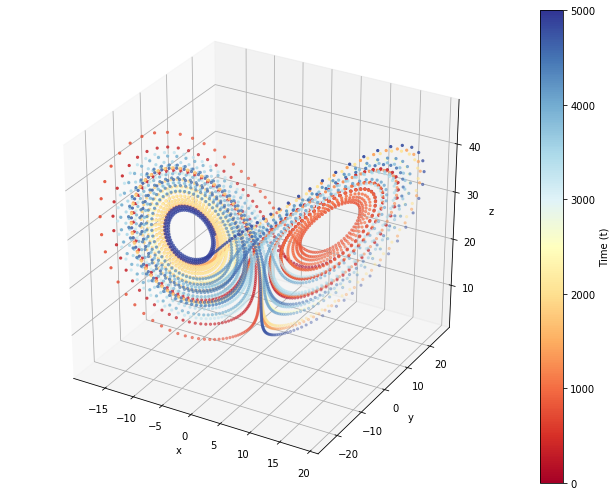

In [6]:
filepath = os.path.join(plot_dir, 'lorenz_data_3d.png')
scatter_plot_3d(x, filename=filepath)

## Take data for one measurement $x(t)$

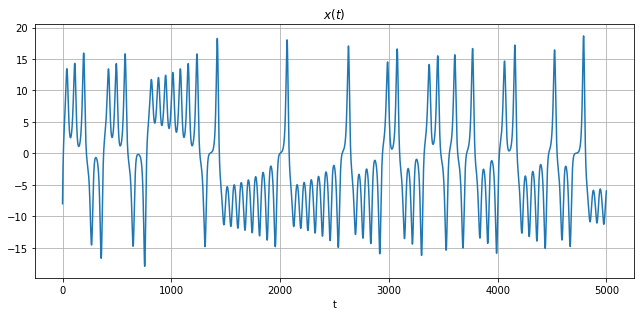

In [7]:
plt.figure(figsize=(9, 4.5))
plt.plot(x[:, 0])
plt.title('$x(t)$')
plt.xlabel('t')
plt.grid()
plt.tight_layout()
filepath = os.path.join(plot_dir, 'lorenz_data_x.png')
plt.savefig(filepath)
plt.show()

In [8]:
def hankel_matrix(x, n_shift):
    """Hankel matrix of eigen-time-delay coordinates.
    """
    assert n_shift > 1
    h = np.stack([np.roll(x, -i) for i in range(n_shift)])
    return h[:, :-n_shift+1]

h_test = hankel_matrix(np.array(range(5)), 3)
h_true = np.array([
    [0, 1, 2],
    [1, 2, 3],
    [2, 3, 4]
])
assert np.array_equal(h_test, h_true)

## Eigen-time delay coordinates

In [9]:
# Number of shifted rows
r = 15
H = hankel_matrix(x[:, 0], r)
H.shape

(15, 4987)

In [10]:
H[:, :5].round(3)

array([[-8.   , -6.486, -5.138, -3.942, -2.882],
       [-6.486, -5.138, -3.942, -2.882, -1.944],
       [-5.138, -3.942, -2.882, -1.944, -1.113],
       [-3.942, -2.882, -1.944, -1.113, -0.375],
       [-2.882, -1.944, -1.113, -0.375,  0.284],
       [-1.944, -1.113, -0.375,  0.284,  0.877],
       [-1.113, -0.375,  0.284,  0.877,  1.414],
       [-0.375,  0.284,  0.877,  1.414,  1.905],
       [ 0.284,  0.877,  1.414,  1.905,  2.36 ],
       [ 0.877,  1.414,  1.905,  2.36 ,  2.787],
       [ 1.414,  1.905,  2.36 ,  2.787,  3.193],
       [ 1.905,  2.36 ,  2.787,  3.193,  3.584],
       [ 2.36 ,  2.787,  3.193,  3.584,  3.966],
       [ 2.787,  3.193,  3.584,  3.966,  4.344],
       [ 3.193,  3.584,  3.966,  4.344,  4.722]])

In [11]:
# Compute SVD
U, S, VT = np.linalg.svd(H, full_matrices=False)
V = VT.T

U.shape, S.shape, V.shape

((15, 15), (15,), (4987, 15))

In [12]:
def gradient_estimate(x, dt):
    """Compute derivatives using 4th-order central difference 
    method.
    
    Args:
        x (array): time-series data 
        dt (float): time-step
    
    Returns:
        x_trimmed (array): Original x array with first and last two rows trimmed
        dx (array): derivative estimates (same size as x_trimmed).
    """
    dx = (1/(12*dt)) * (-x[4:,:] + 8*x[3:-1,:] - 8*x[1:-3,:] + x[:-4,:])
    x_trimmed = x[2:-2]
    return x_trimmed, dx

V, dV = gradient_estimate(V, dt)
assert V.shape == dV.shape
V.shape, dV.shape

((4983, 15), (4983, 15))

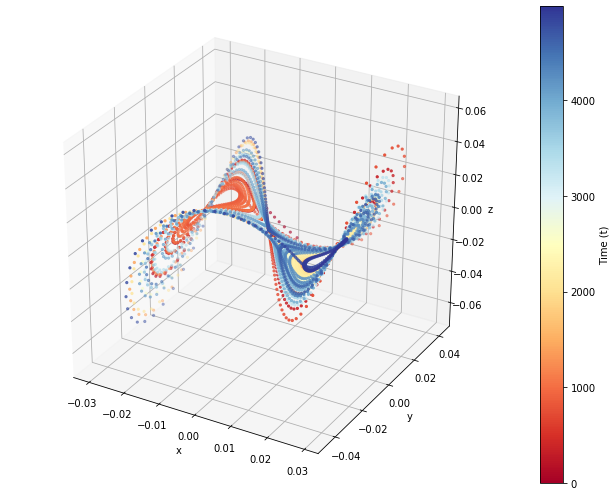

In [13]:
# First 3 columns of V are an embedded attractor of the Lorenz system
filepath = os.path.join(plot_dir, 'lorenz_embedded.png')
scatter_plot_3d(V[:,:3], filename=filepath)

In [14]:
V[:, 9].shape

(4983,)

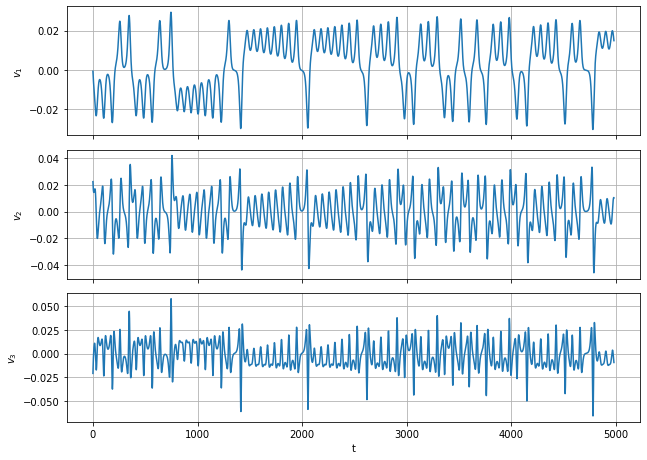

In [15]:
fig, axes = plt.subplots(3, 1, figsize=(9, 6.5), sharex=True)
for i, row in enumerate([0, 1, 2]):
    label = "$v_{%d}$" % (row + 1)
    axes[i].plot(V[:, row], label=label)
    axes[i].set_ylabel(label)
    axes[i].grid()

axes[-1].set_xlabel('t')
plt.tight_layout()
filepath = os.path.join(plot_dir, 'lorenz_data_v.png')
plt.savefig(filepath)
plt.show()

In [16]:
# Rank of HAVOK model (see above)
r

15

## Analyse Forcing Values

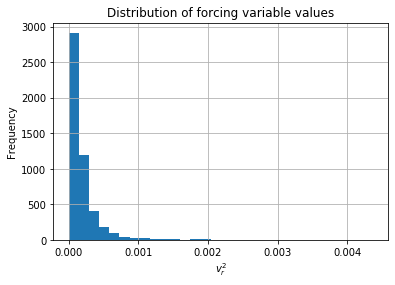

In [17]:
forcing_values = V[:, r-1]**2

plt.hist(V[:, row]**2, bins=30)
plt.title('Distribution of forcing variable values')
plt.xlabel('$v_r^2$')
plt.ylabel('Frequency')
plt.grid()
plt.show()

In [18]:
is_forcing = forcing_values > 0.00001  # Choose threshold

# Fraction of time forcing
round(sum(is_forcing) / len(is_forcing), 4)

0.5081

In [19]:
t_trimmed = t[r//2:r//2 + V.shape[0]]

t.shape, t_trimmed.shape

((5001,), (4983,))

In [20]:
plot_data = {
    "v_1": V[:, 0],
    "v_r^2": V[:, r-1]**2
}
index = pd.Index(t_trimmed, name='t')
plot_data = pd.DataFrame(plot_data, index=index)

plot_data["v_1 not forcing"] = plot_data.loc[~is_forcing, "v_1"]
plot_data["v_1 forcing"] = plot_data.loc[is_forcing, "v_1"]
plot_data["v_r^2 not forcing"] = plot_data.loc[~is_forcing, "v_r^2"]
plot_data["v_r^2 forcing"] = plot_data.loc[is_forcing, "v_r^2"]

plot_data.head()

,v_1,v_r^2,v_1 not forcing,v_1 forcing,v_r^2 not forcing,v_r^2 forcing
t,,,,,,
0.07,-0.000626,0.003408,NaN,-0.000626,NaN,0.003408
0.08,-0.001778,0.001138,NaN,-0.001778,NaN,0.001138
0.09,-0.002830,0.000156,NaN,-0.002830,NaN,0.000156
0.10,-0.003799,0.000013,NaN,-0.003799,NaN,0.000013
0.11,-0.004703,0.000226,NaN,-0.004703,NaN,0.000226


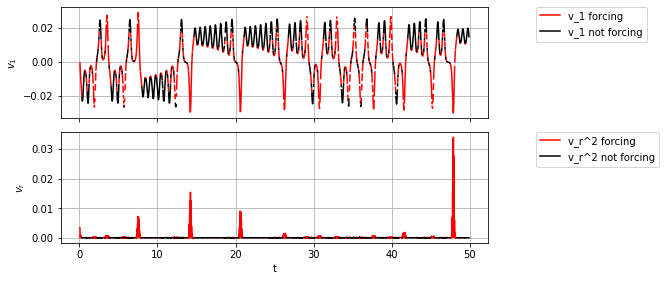

In [21]:
fig, axes = plt.subplots(2, 1, figsize=(9.5, 4), sharex=True)

plot_data['v_1 forcing'].plot(ax=axes[0], style='r-')
plot_data['v_1 not forcing'].plot(ax=axes[0], style='k-')
axes[0].set_ylabel('$v_1$')
axes[0].grid()
axes[0].legend(bbox_to_anchor=(1.1, 1.05))

plot_data['v_r^2 forcing'].plot(ax=axes[1], style='r-')
plot_data['v_r^2 not forcing'].plot(ax=axes[1], style='k-')
axes[1].set_ylabel('$v_r$')
axes[1].grid()
axes[1].legend(bbox_to_anchor=(1.1, 1.05))

axes[1].set_xlabel('t')
plt.tight_layout()
filepath = os.path.join(plot_dir, 'lorenz_data_forcing.png')
plt.savefig(filepath)
plt.show()

## Build HAVOK Regression Model on Time Delay Coordinates

In [22]:
xi = np.linalg.lstsq(V, dV, rcond=None)[0]
xi.shape

(15, 15)

In [23]:
A = xi[:(r-1), :(r-1)].T
B = xi[-1, :(r-1)].T

A.shape, B.shape

((14, 14), (14,))

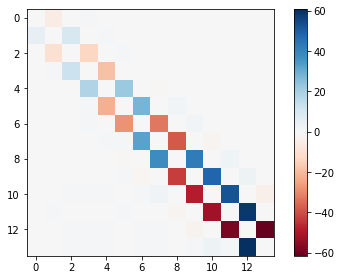

In [24]:
plt.imshow(A, cmap='RdBu')
plt.colorbar()
plt.tight_layout()
filepath = os.path.join(plot_dir, 'lorenz_reg_model.pdf')
plt.savefig(filepath)
plt.show()

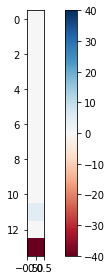

In [25]:
plt.imshow(B.reshape(-1,1), cmap='RdBu')
plt.colorbar()
plt.clim(-40, 40)
plt.tight_layout()
filepath = os.path.join(plot_dir, 'lorenz_reg_model_b.png')
plt.savefig(filepath)
plt.show()

## Make Predictions with the HAVOC Model

In [26]:
np.array([1, 2, 3])[-1]

3

In [27]:
def dxdt_linear(t, x, A):
    dx = A.dot(x)
    
    # Try forcing the last parameter to a fixed value
    #dx[-1] = 0.5 if (np.random.randint(0, 20) == 0) else 0
    return dx

# HAVOK Regression Model
A = xi[:r, :r].T
fun = partial(dxdt_linear, A=A)

# Initial condition
v0 = V[0]
dvdt = fun(0, v0)
dvdt

array([-0.12070229, -0.22157932,  0.44284696,  0.44719564,  0.46474192,
       -0.2624049 ,  0.03331216, -0.3463328 , -0.77158641,  1.2477076 ,
       -1.7216943 ,  2.13219488, -2.13213833, -2.0893291 ,  2.36844558])

In [28]:
rtol = 10e-12
atol = 10e-12
V_havok = odeint(fun, v0, t, tfirst=True, rtol=rtol, atol=atol)
V_havok.shape

(5001, 15)

In [29]:
forcing_values = V_havok[:, r-1]**2

is_forcing = forcing_values > 0.0001  # Choose threshold

# Fraction of time forcing
round(sum(is_forcing) / len(is_forcing), 4)

0.2809

In [30]:
plot_data = {
    "v_1": V_havok[:, 0],
    "v_r^2": V_havok[:, r-1]**2
}
index = pd.Index(t, name='t')
plot_data = pd.DataFrame(plot_data, index=index)

plot_data["v_1 not forcing"] = plot_data.loc[~is_forcing, "v_1"]
plot_data["v_1 forcing"] = plot_data.loc[is_forcing, "v_1"]
plot_data["v_r^2 not forcing"] = plot_data.loc[~is_forcing, "v_r^2"]
plot_data["v_r^2 forcing"] = plot_data.loc[is_forcing, "v_r^2"]

plot_data.head()

,v_1,v_r^2,v_1 not forcing,v_1 forcing,v_r^2 not forcing,v_r^2 forcing
t,,,,,,
0.00,-0.000626,0.003408,NaN,-0.000626,NaN,0.003408
0.01,-0.001778,0.005157,NaN,-0.001778,NaN,0.005157
0.02,-0.002830,0.003398,NaN,-0.002830,NaN,0.003398
0.03,-0.003799,0.000462,NaN,-0.003799,NaN,0.000462
0.04,-0.004703,0.000445,NaN,-0.004703,NaN,0.000445


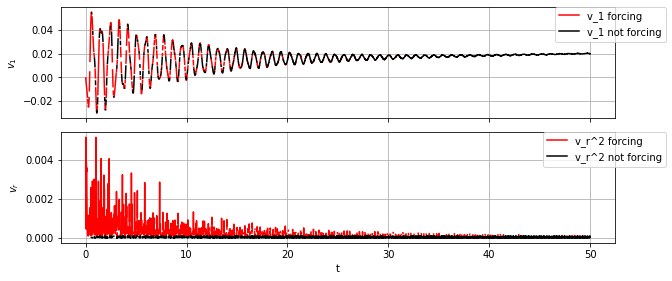

In [31]:
fig, axes = plt.subplots(2, 1, figsize=(9.5, 4), sharex=True)

plot_data['v_1 forcing'].plot(ax=axes[0], style='r-')
plot_data['v_1 not forcing'].plot(ax=axes[0], style='k-')
axes[0].set_ylabel('$v_1$')
axes[0].grid()
axes[0].legend(bbox_to_anchor=(1.1, 1.05))

plot_data['v_r^2 forcing'].plot(ax=axes[1], style='r-')
plot_data['v_r^2 not forcing'].plot(ax=axes[1], style='k-')
axes[1].set_ylabel('$v_r$')
axes[1].grid()
axes[1].legend(bbox_to_anchor=(1.1, 1.05))

axes[1].set_xlabel('t')
plt.tight_layout()
filepath = os.path.join(plot_dir, 'havok_lorenz_prediction.png')
plt.savefig(filepath)
plt.show()